In [55]:
import os.path
from math import log, exp
import numpy as np
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD

In [58]:
% matplotlib inline
#conf = SparkConf().setMaster("local").setAppName("My App")
#sc = SparkContext(conf=conf)

### Read data

In [24]:
filePath = os.path.join('data','abalone_data.csv')

numPartitions = 2
rawData = (sc.
           textFile(filePath).
           map(lambda line: line.split(",")))  # is this necessary?

###Convert to LabeledPoint of Numpy array

In [34]:
def label_map(clss):
    if clss == "M":
        return 0
    else:
        return 1

def line_to_labeled(lst):
    """Map a list of items to LabeledPoint of (label, numpy array)
    """
    return LabeledPoint(label_map(lst[0]), np.array([float(el) for el in lst[1:]]) )

ex = rawData.take(1)
#print ex
#print line_to_labeled(ex[0])
labeledPointData = rawData.map(lambda ls: line_to_labeled(ls))
print labeledPointData.take(1)

[LabeledPoint(0.0, [0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0])]


### Split into train-test-validation

In [35]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
labeledTrainData, labeledValidationData, labeledTestData = labeledPointData.randomSplit(weights, seed)  # <FILL IN>
# Cache the data
labeledTrainData.cache()
labeledValidationData.cache()
labeledTestData.cache()

nTrain = labeledTrainData.count()  # <FILL IN>
nVal = labeledValidationData.count()  # <FILL IN>
nTest = labeledTestData.count()  # <FILL IN>
print nTrain, nVal, nTest, nTrain + nVal + nTest
print labeledPointData.take(1)

3359 416 402 4177
[LabeledPoint(0.0, [0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0])]


### Set parameters and train logistic regression

In [37]:
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [39]:
model0 = LogisticRegressionWithSGD.train(labeledTrainData,
                                         iterations=numIters,
                                         step=stepSize,
                                         regParam=regParam,
                                         regType=regType,
                                         intercept=includeIntercept)  # <FILL IN>
sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept

[-4.0979135662854862, -1.9276307937301758, -1.0111253065652182, -0.85237866379792626, -0.054813505521983399] 3.97218343737


In [42]:
def computeLogLoss(p, y):
    """Calculate the value of log loss for a given probabilty and label.
    """
    epsilon = 10e-12
    return (float(y) - 1.) * log(1-p+epsilon) - float(y) * log(p+epsilon)

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    """
    rawPrediction = intercept + w.dot(x)

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1/(1 + exp(-1 * rawPrediction))  # <FILL IN>

In [43]:
trainingPredictions = labeledTrainData.map(lambda x: getP(x.features, model0.weights, model0.intercept))
print trainingPredictions.take(10)

[0.9999999162541965, 0.9999447107702242, 0.9999215613979342, 0.9999871975871831, 0.9999511845150241, 0.9999606461932551, 0.9999999979373282, 0.9999998851648239, 0.9999999894861461, 0.9999929137814919]


#### What is the class imbalance in the data?

In [66]:
classOneFraction = (labeledTrainData.
                    map(lambda x: float(x.label)).
                    mean())
logLossTrBase = computeLogLoss(classOneFraction, 1.)
print "Train Data:"
print "\tClass one fraction is: %4.3f" % classOneFraction
print "\tBaseline log-loss: %4.3f" % logLossTrBase

classOneFractionTs = (labeledTestData.
                    map(lambda x: float(x.label)).
                    mean())
logLossTsBase = computeLogLoss(classOneFractionTs, 1.)
print "Train Data:"
print "\tClass one fraction is: %4.3f" % classOneFractionTs
print "\tBaseline log-loss: %4.3f" % logLossTsBase

classOneFractionVl = (labeledValidationData.
                    map(lambda x: float(x.label)).
                    mean())
logLossValBase = computeLogLoss(classOneFractionVl, 1.)
print "Train Data:"
print "\tClass one fraction is: %4.3f" % classOneFractionVl
print "\tBaseline log-loss: %4.3f" % logLossVlBase


Train Data:
	Class one fraction is: 0.634
	Baseline log-loss: 0.456
Train Data:
	Class one fraction is: 0.604
	Baseline log-loss: 0.503
Train Data:
	Class one fraction is: 0.663
	Baseline log-loss: 0.410


#### Log loss on train, test, validate data

In [53]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.
    """
    return (data
            .map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), float(x.label)))
            .mean())

logLossTrLR0 = evaluateResults(model0, labeledTrainData)
logLossTsLR0 = evaluateResults(model0, labeledTestData)
logLossVlLR0 = evaluateResults(model0, labeledValidationData)

print ('Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))
print ('Test Logloss:\n\tLogReg = {0:.3f}'
       .format(logLossTsLR0))
print ('Validate Logloss:\n\tLogReg = {0:.3f}'
       .format(logLossVlLR0))

Train Logloss:
	Baseline = 0.456
	LogReg = 3.428
Test Logloss:
	LogReg = 3.837
Validate Logloss:
	LogReg = 3.137


In [56]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

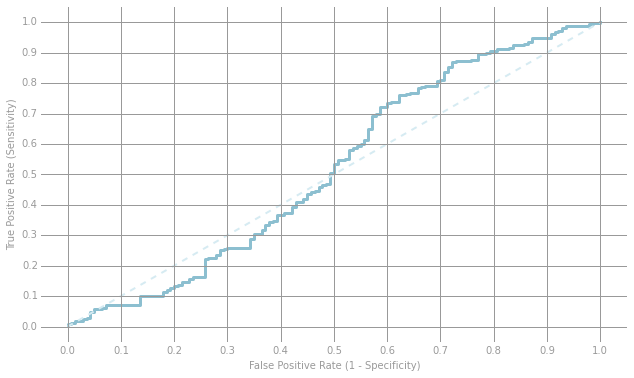

In [59]:
labelsAndScores = labeledValidationData.map(lambda lp:
                                            (float(lp.label), getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass

### Scan parameters and choose best model based on log loss

In [61]:
numIters = 500
regType = 'l2'
includeIntercept = True

# Initialize variables using values from initial model training
bestModel = None
bestLogLoss = 1e10

In [65]:
stepSizes = [3, 6, 9, 12, 15, 18]
regParams = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(labeledTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, labeledValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 3.0, regParam = 1e-07: logloss = 1.026
	stepSize = 3.0, regParam = 1e-06: logloss = 1.027
	stepSize = 3.0, regParam = 1e-05: logloss = 1.027
	stepSize = 3.0, regParam = 1e-04: logloss = 1.026
	stepSize = 3.0, regParam = 1e-03: logloss = 1.022
	stepSize = 3.0, regParam = 1e-02: logloss = 0.990
	stepSize = 6.0, regParam = 1e-07: logloss = 1.010
	stepSize = 6.0, regParam = 1e-06: logloss = 3.362
	stepSize = 6.0, regParam = 1e-05: logloss = 3.361
	stepSize = 6.0, regParam = 1e-04: logloss = 3.378
	stepSize = 6.0, regParam = 1e-03: logloss = 3.460
	stepSize = 6.0, regParam = 1e-02: logloss = 3.717
	stepSize = 9.0, regParam = 1e-07: logloss = 3.355
	stepSize = 9.0, regParam = 1e-06: logloss = 5.335
	stepSize = 9.0, regParam = 1e-05: logloss = 5.166
	stepSize = 9.0, regParam = 1e-04: logloss = 1.983
	stepSize = 9.0, regParam = 1e-03: logloss = 3.536
	stepSize = 9.0, regParam = 1e-02: logloss = 0.654
	stepSize = 12.0, regParam = 1e-07: logloss = 1.038
	stepSize = 12.0, regParam = 1

In [68]:
stepSizes = [7, 8, 9, 10, 11]
regParams = [5e-3, 7.5e-3, 1e-2, 1.25e-2, 1.5e-2]
for stepSize in stepSizes:
    for regParam in regParams:
        model = (LogisticRegressionWithSGD
                 .train(labeledTrainData, numIters, stepSize, regParam=regParam, regType=regType,
                        intercept=includeIntercept))
        logLossVa = evaluateResults(model, labeledValidationData)
        print ('\tstepSize = {0:.1f}, regParam = {1:.0e}: logloss = {2:.3f}'
               .format(stepSize, regParam, logLossVa))
        if (logLossVa < bestLogLoss):
            bestModel = model
            bestLogLoss = logLossVa

print ('Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, bestLogLoss))

	stepSize = 7.0, regParam = 5e-03: logloss = 4.578
	stepSize = 7.0, regParam = 7e-03: logloss = 4.620
	stepSize = 7.0, regParam = 1e-02: logloss = 4.755
	stepSize = 7.0, regParam = 1e-02: logloss = 1.681
	stepSize = 7.0, regParam = 1e-02: logloss = 4.192
	stepSize = 8.0, regParam = 5e-03: logloss = 2.876
	stepSize = 8.0, regParam = 7e-03: logloss = 2.275
	stepSize = 8.0, regParam = 1e-02: logloss = 1.728
	stepSize = 8.0, regParam = 1e-02: logloss = 4.448
	stepSize = 8.0, regParam = 1e-02: logloss = 0.691
	stepSize = 9.0, regParam = 5e-03: logloss = 4.559
	stepSize = 9.0, regParam = 7e-03: logloss = 5.372
	stepSize = 9.0, regParam = 1e-02: logloss = 0.654
	stepSize = 9.0, regParam = 1e-02: logloss = 6.289
	stepSize = 9.0, regParam = 1e-02: logloss = 0.706
	stepSize = 10.0, regParam = 5e-03: logloss = 2.519
	stepSize = 10.0, regParam = 7e-03: logloss = 6.253
	stepSize = 10.0, regParam = 1e-02: logloss = 5.685
	stepSize = 10.0, regParam = 1e-02: logloss = 6.212
	stepSize = 10.0, regParam 

### Plot ROC curve on validation data, for the best model found on the scan

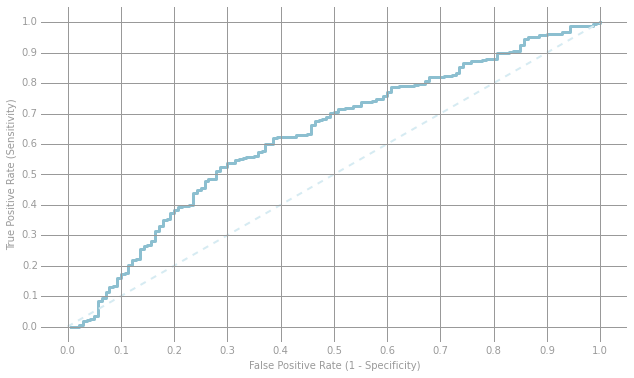

In [69]:
labelsAndScores = labeledValidationData.map(lambda lp:
                                            (float(lp.label), getP(lp.features, bestModel.weights, bestModel.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass